# Information Retrieval - Quora Question Pairs challenge
by Kevin Nanhekhan (student-no. 4959094)

In [1]:
import json
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import ShuffleSplit, HalvingGridSearchCV, GridSearchCV
from sklearn.metrics.pairwise import cosine_distances
from xgboost import XGBClassifier
nltk.download('wordnet')
nltk.download('stopwords')
STOPWORDS = stopwords.words("english")
RANDOM_STATE = 42

C:\Users\kevin\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('data/Development set.csv', index_col='id')
data.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


<AxesSubplot: >

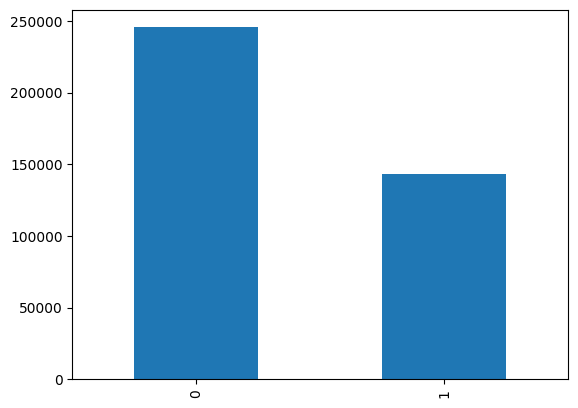

In [3]:
# Dataset has an imbalance when looking at the amount of non-duplicated vs duplicated questions
data['is_duplicate'].value_counts().plot.bar()

# Initial Solution
Perform string matching and basic preprocessing on the question text (e.g. lower case, replace characters, lematization, stopword removal)

In [2]:
def text_preprocess(txt):
    def replace_all(t, dic):
        for i, j in dic.items():
            t = t.replace(i, j)
        return t

    # Change text to be lowercase.
    txt = str(txt).lower()

    # Load dictionary for character & contraction replacements
    with open('data/replacechars.json', 'r') as JSON:
        json_dict = json.load(JSON)

    # Replace contractions, currencies, magnitude of order and other characters
    text = replace_all(txt, json_dict)
    text = re.sub(r'([0-9]+)000000000', r'\1b', text)
    text = re.sub(r'([0-9]+)000000', r'\1m', text)
    text = re.sub(r'([0-9]+)000', r'\1k', text)

    # Lemmatize text (e.g. corpora -> corpus)
    text =  WordNetLemmatizer().lemmatize(text)

    # Remove non-word characters (e.g. %, !, etc.)
    text = re.sub('\W', ' ', text)

    # Remove hyperlinks (e.g. https://www.myloancare.in/car-lo...)
    text = re.sub(r"http\S+", "", text)

    # Remove stopwords from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])

    return text.strip()

In [12]:
def string_matching(df_name):
    df_str = pd.read_csv(df_name, index_col='id')
    df_str['question1'] = df_str['question1'].fillna("").apply(text_preprocess)
    df_str['question2'] = df_str['question2'].fillna("").apply(text_preprocess)
    df_str['is_duplicate'] = (df_str['question1'] == df_str['question2']).astype(int)
    return df_str

Accuracy score: 0.69760


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

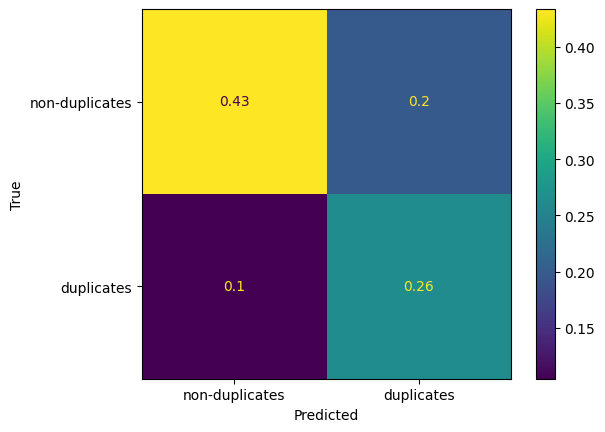

In [6]:
df_string_match = string_matching('data/Development set.csv')
y_true = df_string_match['is_duplicate'].values
y_pred = string_matching(df_string_match)['is_duplicate'].values
print(f'Accuracy score: {accuracy_score(y_true, y_pred):.5f}')

cm = confusion_matrix=confusion_matrix(y_true, y_pred, normalize="all")
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-duplicates', 'duplicates'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

In [13]:
# Creating prediction results csv for Kaggle
# df_string_match = string_matching('data/Test set.csv')
# df_string_match['is_duplicate'].to_csv('results/string_match.csv')

# Improvement towards advanced solution
### Feature extraction

In [3]:
# Helper method for extracting basic features (calculations based on the length and number of occurences)
def basic_features(row):
    features = [0.0]*9
    q1_set = set(row['question1'].split(" "))
    q2_set = set(row['question2'].split(" "))

    features[0] = len(row['question1'])             # length of q1
    features[1] = len(row['question2'])             # length of q2
    features[2] = abs(features[0] - features[1])    # difference in length of the questions
    features[3] = len({*row['question1']})          # Number of characters in q1
    features[4] = len({*row['question2']})          # Number of characters in q2
    features[5] = len(q1_set & q2_set)              # Common words in q1 and q2
    features[6] = (len(q1_set) + len(q2_set))/2     # Average length of the words in q1 and q2
    features[7] = len(row['question1'].split(" "))  # Number of words in q1
    features[8] = len(row['question2'].split(" "))  # Number of words in q2

    return features

# Helper method for extracting fuzzy features
def fuzzy_features(row):
    features = [0.0] * 7
    features[0] = fuzz.QRatio(row['question1'], row['question2']) # quick ratio comparison
    features[1] = fuzz.WRatio(row['question1'], row['question2']) # weighted ratio comparison
    features[2] = fuzz.partial_ratio(row['question1'], row['question2']) # partial ratio
    features[3] = fuzz.token_set_ratio(row['question1'], row['question2']) # Token set ratio
    features[4] = fuzz.token_sort_ratio(row['question1'], row['question2']) # Token sort ratio
    features[5] = fuzz.partial_token_set_ratio(row['question1'], row['question2']) # Partial token set ratio
    features[6] = fuzz.partial_token_sort_ratio(row['question1'], row['question2']) # Partial token sort ratio

    return features

def dataframe_features(df_name, readfile=True):
    if readfile:
        return pd.read_csv(f'data/{df_name} features.csv', index_col='id')
    else:
        # training set
        df_features = pd.read_csv(f"data/{df_name} set.csv", index_col='id')

        # Remove redundant question id's and rows with empty and NaN values
        df_features.drop(columns=['qid1', 'qid2'], inplace=True)
        if df_name == "Test":
            df_features.drop(columns=['?'], inplace=True)
        df_features.replace('', np.nan, inplace=True)
        df_features.dropna(inplace=True)

        # Text preprocessing
        df_features['question1'] = df_features['question1'].apply(text_preprocess)
        df_features['question2'] = df_features['question2'].apply(text_preprocess)

        # Extract features by looking at length, average of the questions
        df_features[['q1_len', 'q2_len', 'diff', 'q1_char', 'q2_char', 'common', 'avg_len', 'q1_words', 'q2_words']] = df_features.apply(basic_features, axis=1, result_type='expand')

        # Use Fuzz Wuzzy library for getting similarity index (between 0-100) through string matching
        df_features[['fz_qratio', 'fz_wratio', 'fz_partial', 'fz_token_set', 'fz_token_sort', 'fz_partial_set', 'fz_partial_sort']] = df_features.apply(fuzzy_features, axis=1, result_type='expand')
        df_features.fillna(0, inplace=True)

        df_features.to_csv(f'data/{df_name} features.csv')

        return df_features

### Random Forest Classifier predictions

In [5]:
def rf_hyperparameter_tuning():
    rf_train = dataframe_features('Development')
    rf_train.drop(columns=['question1', 'question2'], inplace=True)
    rf_train_x = rf_train.loc[:, rf_train.columns!='is_duplicate'].values
    rf_train_y = rf_train['is_duplicate'].values

    shuffle = ShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
    scoring = {"acc": make_scorer(accuracy_score), "f1": make_scorer(f1_score)}
    rf_param_grid = {
        'n_estimators':[25, 50, 75, 100, 150],
        'min_samples_split':[5, 7, 10, 12, 15],
        'max_depth': [75, 100, 150, 175, 200, None]
    }
    rf_search = HalvingGridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_param_grid, scoring="accuracy", cv=shuffle, verbose=3, random_state=RANDOM_STATE)
    # rf_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_param_grid, scoring=scoring, refit="acc", cv=shuffle, verbose=3) # Takes too long
    rf_search.fit(rf_train_x, rf_train_y)
    print(f"Best parameters found for RandomForestClassifier: {rf_search.best_params_}, best accuracy score: {rf_search.best_score_:.5f}")

rf_hyperparameter_tuning()

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 4799
max_resources_: 388798
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 150
n_resources: 4799
Fitting 1 folds for each of 150 candidates, totalling 150 fits
[CV 1/1] END max_depth=75, min_samples_split=5, n_estimators=25;, score=(train=0.981, test=0.730) total time=   0.1s
[CV 1/1] END max_depth=75, min_samples_split=5, n_estimators=50;, score=(train=0.986, test=0.728) total time=   0.3s
[CV 1/1] END max_depth=75, min_samples_split=5, n_estimators=75;, score=(train=0.988, test=0.723) total time=   0.7s
[CV 1/1] END max_depth=75, min_samples_split=5, n_estimators=100;, score=(train=0.989, test=0.719) total time=   1.0s
[CV 1/1] END max_depth=75, min_samples_split=5, n_estimators=150;, score=(train=0.989, test=0.715) total time=   1.0s
[CV 1/1] END max_depth=75, min_samples_split=7, n_estimators=25;, score=(train=0.972, test=0.747) total time=   0.1s
[CV 1/1] END max_depth=75, m

In [9]:
def rf_predictions():
    rf_train = dataframe_features('Development', readfile=True)
    rf_train.drop(columns=['question1', 'question2'], inplace=True)
    rf_train_x = rf_train.loc[:, rf_train.columns!='is_duplicate'].values
    rf_train_y = rf_train['is_duplicate'].values

    rf_test = dataframe_features('Test', readfile=True)
    rf_test.drop(columns=['question1', 'question2'], inplace=True)
    test_x = rf_test.values

    cf = RandomForestClassifier(max_depth=None, min_samples_split=15, n_estimators=150)
    cf.fit(rf_train_x, rf_train_y)
    rf_test['is_duplicate'] = cf.predict(test_x)
    return rf_test

df_random_forrest = rf_predictions()
df_random_forrest['is_duplicate'].to_csv('results/random_forrest.csv')

### Gradient Boosted Trees Classifier (XGB) predictions

In [6]:
def xgb_hyperparameter_tuning():
    xgb_train = dataframe_features('Development', readfile=True)
    xgb_train.drop(columns=['question1', 'question2'], inplace=True)
    xgb_train_x = xgb_train.loc[:, xgb_train.columns!='is_duplicate'].values
    xgb_train_y = xgb_train['is_duplicate'].values

    shuffle = ShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
    scoring = {"acc": make_scorer(accuracy_score), "f1": make_scorer(f1_score)}
    xgb_param_grid = {
        'n_estimators':[25, 50, 75, 100, 200, 500, 800],
        'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.5],
        'min_child_weight':[1, 3, 5, 7, 10],
        'max_depth': [3, 4, 5, 6, None]
    }
    xgb_search = HalvingGridSearchCV(estimator=XGBClassifier(), param_grid=xgb_param_grid, scoring="accuracy", cv=shuffle, verbose=3, random_state=RANDOM_STATE)
    # xgb_search = GridSearchCV(estimator=XGBClassifier(), param_grid=xgb_param_grid, scoring=scoring, refit="acc", cv=shuffle, verbose=3) # Takes too long
    xgb_search.fit(xgb_train_x, xgb_train_y)
    print(f"Best parameters found for XGBClassifier: {xgb_search.best_params_}, best accuracy score: {xgb_search.best_score_:.5f}")

xgb_hyperparameter_tuning()

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 533
max_resources_: 388798
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 875
n_resources: 533
Fitting 1 folds for each of 875 candidates, totalling 875 fits
[CV 1/1] END learning_rate=0.005, max_depth=3, min_child_weight=1, n_estimators=25;, score=(train=0.772, test=0.745) total time=   0.0s
[CV 1/1] END learning_rate=0.005, max_depth=3, min_child_weight=1, n_estimators=50;, score=(train=0.775, test=0.736) total time=   0.0s
[CV 1/1] END learning_rate=0.005, max_depth=3, min_child_weight=1, n_estimators=75;, score=(train=0.782, test=0.726) total time=   0.0s
[CV 1/1] END learning_rate=0.005, max_depth=3, min_child_weight=1, n_estimators=100;, score=(train=0.782, test=0.708) total time=   0.0s
[CV 1/1] END learning_rate=0.005, max_depth=3, min_child_weight=1, n_estimators=200;, score=(train=0.786, test=0.698) total time=   0.0s
[CV 1/1] END learning_rate=0.005, max_depth=3, min_c

In [11]:
def xgb_predictions():
    xgb_train = dataframe_features('Development', readfile=True)
    xgb_train.drop(columns=['question1', 'question2'], inplace=True)
    xgb_train_x = xgb_train.loc[:, xgb_train.columns!='is_duplicate'].values
    xgb_train_y = xgb_train['is_duplicate'].values

    xgb_test = dataframe_features('Test', readfile=True)
    xgb_test.drop(columns=['question1', 'question2'], inplace=True)
    xgb_test_x = xgb_test.values

    xgb = XGBClassifier(learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=100)
    xgb.fit(xgb_train_x, xgb_train_y)
    xgb_test['is_duplicate'] = xgb.predict(xgb_test_x)
    return xgb_test

df_xgb = xgb_predictions()
df_xgb['is_duplicate'].to_csv('results/xgb.csv')

### Neural Network -->


### Final solution: Ensemble XGB + Neural Network